In [1]:
from scipy.io import wavfile#necessary to import wavefiles. Important: "wavfile", not "wavefile"
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import blackman
import matplotlib.pyplot as plt
import numpy as np#includes important mathematical functions, such as log10(), abs(), etc.
import sounddevice as sd#to play back sounds
import warnings#necessary to suppress the display of warnings when your wave file contains unexpected chunks
import librosa#standard library for audio analysis and feature extraction
import librosa.display
import IPython.display as ipd#can play audio files with a simple GUI
import os#library for file paths, etc.
import statistics as stat#for mean cvalues, etc

C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


SystemError: initialization of _internal failed without raising an exception

# One Example

# Data Import and Preparation

In [1]:
import pandas as pd
import seaborn as sns#for plotting some data
from sklearn.ensemble import RandomForestClassifier# "Ask the Audience" -> A bunch of decision trees guesses
from sklearn.svm import SVC# Support Vector Machines transform the data and search for the optimal separation hyperplanes
from sklearn import svm
from sklearn.neural_network import MLPClassifier# Multi Layer Perceptron, the "classical" neural network
from sklearn.metrics import confusion_matrix, classification_report# To calculate and display classification performance
from sklearn.preprocessing import StandardScaler, LabelEncoder# to normalize the data
from sklearn.model_selection import train_test_split# Splitting the data into training and evaluation data

First, you have to load a dataset, which is often included in one or many csv files. You should print some entries to ensure that the data looks as expected.

In [2]:
#load dataset:
drumtypes = pd.read_csv('arbitrary_drims.csv')
drumtypes.head()#prints the first 5 rows for an overview of the data

,f1,f2,f3,f4,f5,class
0,11519,3,-32768,32764,1254.803165,0
1,14030,116,-32767,27232,40.455868,0
2,16344,7813,-32768,32767,1.002877,0
3,12164,44,-21017,32767,67.288722,0
4,22293,-1,-32767,31909,-3465.763859,0


Check for the dimensions of the matrix: How many rows (individual items) and columns (features)? Are there undesired NaN-values (null)? Are the features numerical or strings?

In [3]:
drumtypes.info()#prints information about format and indicates whether we have null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      168 non-null    int64  
 1   f2      168 non-null    int64  
 2   f3      168 non-null    int64  
 3   f4      168 non-null    int64  
 4   f5      168 non-null    float64
 5   class   168 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 8.0 KB


Next, you should check how many classes are contained in your dataset:

In [5]:
drumtypes['class'].unique()#only works if you have a class column labeled as "class"

array([0, 1, 2, 3, 4], dtype=int64)

You should also check the frequencies of each class (ideally, each class has the same number of items):

In [40]:
drumtypes['class'].value_counts()#tells you how many members each class has. The more similar, the better

3    74
4    38
0    24
2    14
1    10
Name: class, dtype: int64

Now, you separate the class vector (y) from the feature matrix (X) and display how many items and features you've got):

In [7]:
y = drumtypes['class']#these are the class labels that need to be predicted by the clasifier
X = drumtypes.drop(['class'], axis = 1)# these are the features, excluding the classes
print(f'X : {X.shape}')

X : (168, 5)


Split the data into a training data set (train), and an evaluation data set (test). Using 80% for training and 20% for evaluation is quite common:

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)#46&73&74&77-> .812
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (134, 5)
y_train : (134,)
X_test : (34, 5)
y_test : (34,)


# Random Forest Model

The machine learning is just a one-liner. You transform the X_train (features) in such way that it results in the y_train (classes) according to the rules and metrics of the classifier using fit(). You memorize this transform. And you should display how well this worked for the training data:

In [78]:
rf = RandomForestClassifier()#load an instance of the RF classifier
#rfn = RandomForestClassifier(n_estimators=100)#here you can manually set the desired number of trees in the forest
rf.fit(X_train, y_train)#train the classifier on the train data
#Plot acuracy: A train accuracy near 1 can indicate over-fitting, or very explanatory features
# the higher the test accuracy, the better. To be sure, repeat with multiple seeds and calculate mean acc. & 95% Confidence
# intervals or standard deviation
print(f'Train Accuracy: {rf.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {rf.score(X_test, y_test):.3f}')

Train Accuracy: 1.000
Test Accuracy: 0.471


A high training accuracy may indicate that each class clusters well and different classes separate well. Or it means that you over-fitted, i.e., that the machine learning captures every outlier instead of capturing the overall trends and tendencies  within the data. The higher the test accuracy, the better. When the test accuracy is low, this usually means that the features are not explanatory. But it can also mean that the machine learning algorithm is not able to find the structure behind the data distribution.

In systematic musicology, we tend to have typologies, not classes. Classes are defined according to requirements that separates the class from other classes. Classes are mutually exclusive, i.e., one item can never belong to more than one class. One example for classes in musicology are the classes of musical instruments according to the oscillator: chordophones, membranophones, brass instruments (human lips vibrating), woodwind instruments (vibrating reed or air oscillation due to edge or blade), idiophones and electrophones. In contrast, musical genres are typologies. One music piece can be allocated, e.g., to both rock and hip hop. While each genre can be described in terms of typical elements, these are neither unique, nor exclusive to the genre.

In the field of computer science, there used to be a focus on the performance of the machine learnign algorithm. The assumption is: When we have a dataset with a ground truth, i.e., objective class labels, the machine learning algorithm should be able to reproduce the ground truth as good as possible. Hence, they introduced metrics that enables them to compare the performance of different machine learning tools. These are the precision (correctly classified as x divided by all classified as x), recall (correctly classified as x divided by all items of the class x), f1-score (harmonic mean of precision and recall), accuracy (percentage of correct classifications), and, sometimes, the confusion matrix (true class over classified class):

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.25      0.14      0.18         7
           2       1.00      1.00      1.00         1
           3       0.20      0.12      0.15         8
           4       0.50      1.00      0.67        11

    accuracy                           0.47        34
   macro avg       0.59      0.51      0.49        34
weighted avg       0.50      0.47      0.41        34

[[ 2  2  0  2  1]
 [ 0  1  0  2  4]
 [ 0  0  1  0  0]
 [ 0  1  0  1  6]
 [ 0  0  0  0 11]]
Train Accuracy: 1.000
Test Accuracy: 0.471


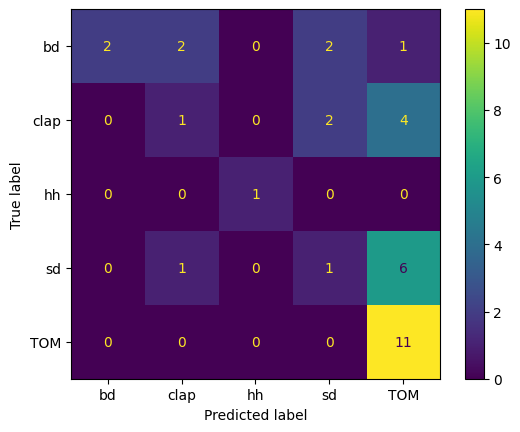

In [164]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay# to display confusion matrix
rf_predict = rf.predict(X_test)
cm = confusion_matrix(y_test, rf_predict)
labels = ['bd', 'clap','hh','sd', 'TOM']
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()# plots pretty confusion matrix
print(classification_report(y_test, rf_predict))# reports precision, recall, f1-score and support
print(confusion_matrix(y_test, rf_predict))# plots confusion matrix in text form
print(f'Train Accuracy: {rf.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {rf.score(X_test, y_test):.3f}')

You can take a look at every single item to see the actual class and the predicted class (for all data):

In [61]:
npdrumtypes = drumtypes.to_numpy()# converts the DataFrame to a numpy array
classification=[0]*len(npdrumtypes)
for i in range(len(npdrumtypes)):
    classification[i]=[i, rf.predict(X)[i],int(npdrumtypes[i,5])]#produces an array with item number, predicted class and actual class
classification

[[0, 3, 0],
 [1, 0, 0],
 [2, 1, 0],
 [3, 0, 0],
 [4, 3, 0],
 [5, 1, 0],
 [6, 4, 0],
 [7, 0, 0],
 [8, 0, 0],
 [9, 0, 0],
 [10, 0, 0],
 [11, 0, 0],
 [12, 0, 0],
 [13, 0, 0],
 [14, 0, 0],
 [15, 0, 0],
 [16, 0, 0],
 [17, 0, 0],
 [18, 0, 0],
 [19, 0, 0],
 [20, 0, 0],
 [21, 0, 0],
 [22, 0, 0],
 [23, 0, 0],
 [24, 0, 0],
 [25, 0, 0],
 [26, 0, 0],
 [27, 0, 0],
 [28, 0, 0],
 [29, 0, 0],
 [30, 0, 0],
 [31, 1, 1],
 [32, 1, 1],
 [33, 1, 1],
 [34, 1, 1],
 [35, 1, 1],
 [36, 1, 1],
 [37, 1, 1],
 [38, 0, 1],
 [39, 1, 1],
 [40, 1, 1],
 [41, 1, 1],
 [42, 1, 1],
 [43, 1, 1],
 [44, 1, 1],
 [45, 1, 1],
 [46, 1, 1],
 [47, 1, 1],
 [48, 1, 1],
 [49, 1, 1],
 [50, 1, 1],
 [51, 4, 1],
 [52, 4, 1],
 [53, 1, 1],
 [54, 4, 1],
 [55, 1, 1],
 [56, 1, 1],
 [57, 1, 1],
 [58, 1, 1],
 [59, 4, 1],
 [60, 1, 1],
 [61, 4, 1],
 [62, 2, 2],
 [63, 2, 2],
 [64, 2, 2],
 [65, 2, 2],
 [66, 2, 2],
 [67, 2, 2],
 [68, 2, 2],
 [69, 2, 2],
 [70, 2, 2],
 [71, 2, 2],
 [72, 2, 2],
 [73, 2, 2],
 [74, 2, 2],
 [75, 2, 2],
 [76, 2, 2],
 [77, 2, 

Or just for the test data:

In [67]:
testies = y_test.to_numpy()# converts the DataFrame to a numpy array
classification=[0]*len(testies)
for i in range(len(testies)):
    classification[i]=[i, rf.predict(X_test)[i],int(testies[i])]#produces an array with item number, predicted class and actual class
classification

[[0, 3, 3],
 [1, 1, 1],
 [2, 4, 3],
 [3, 4, 1],
 [4, 4, 1],
 [5, 4, 4],
 [6, 4, 0],
 [7, 4, 4],
 [8, 4, 3],
 [9, 4, 3],
 [10, 3, 0],
 [11, 4, 1],
 [12, 1, 0],
 [13, 4, 4],
 [14, 2, 2],
 [15, 4, 1],
 [16, 4, 3],
 [17, 4, 1],
 [18, 3, 0],
 [19, 4, 4],
 [20, 4, 3],
 [21, 4, 4],
 [22, 4, 3],
 [23, 1, 3],
 [24, 4, 4],
 [25, 4, 4],
 [26, 4, 4],
 [27, 1, 0],
 [28, 4, 4],
 [29, 0, 0],
 [30, 4, 4],
 [31, 0, 0],
 [32, 0, 1],
 [33, 4, 4]]

For scientific purposes, it may be sufficient to split your data into training data and test data to present a proof of concept. However, in many field you train a model once, to use it in the future. In such cases, you have to save the trained model in a file, maybe transfer it to another user, who then loads and applies it. This can be done by means of a joblib file:

In [70]:
import joblib
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

joblib.dump(rf,"random_forest.joblib")# for 
joblib.dump(rf, "RF_compressed.joblib", compress=3)# for a compressed file with a smaller file size

['RF_compressed.joblib']

And import it:

In [72]:
loaded_rf = joblib.load("random_forest.joblib")
# This is just to ensure that the loaded machine learning model is equal to the original one:
loaded_rf.predict(X)-rf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Some machine learning algorithms need normalized data in which all features have the same order of magnitude. The standard scaler carries out a linear transform such that the mean value is 0 and the standard deviation is 1:

In [74]:
sc = StandardScaler()
X = sc.fit_transform(X)
# Naturally, you need to create new train and test data from the normalized matrix:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=6)

In [77]:
rfn = RandomForestClassifier(n_estimators=100)#here you can manually set the desired number of trees in the forest
rfn.fit(X_train,y_train)
predict = rfn.predict(X_test)

# SVM Classifier

In [83]:
clf=svm.SVC()
clf.fit(X_train, y_train)
pred_clf = clf.predict(X_test)
print(f'Train Accuracy: {clf.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')

Train Accuracy: 0.410
Test Accuracy: 0.353


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         7
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         8
           4       0.34      1.00      0.51        11

    accuracy                           0.35        34
   macro avg       0.27      0.40      0.30        34
weighted avg       0.14      0.35      0.19        34

[[ 0  0  0  0  7]
 [ 0  0  0  0  7]
 [ 0  0  1  0  0]
 [ 0  1  0  0  7]
 [ 0  0  0  0 11]]


C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

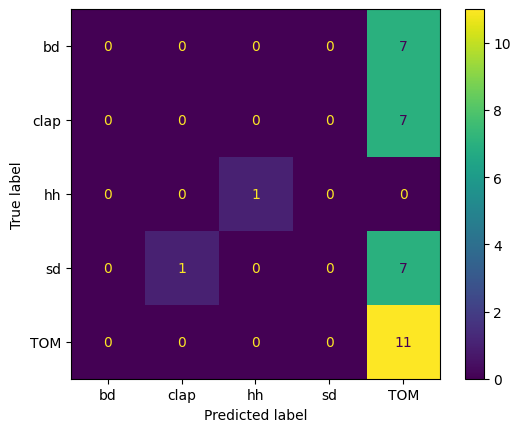

In [85]:
print(classification_report(y_test, pred_clf))
print(confusion_matrix(y_test, pred_clf))
cm = confusion_matrix(y_test, pred_clf)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

# Neural Network (Multi Layer Perceptron)

In [86]:
mlpc = MLPClassifier(hidden_layer_sizes=(11,11,11), max_iter=500)
mlpc.fit(X_train,y_train)
pred_mlpc = mlpc.predict(X_test)
print(f'Train Accuracy: {mlpc.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {mlpc.score(X_test, y_test):.3f}')

Train Accuracy: 0.485
Test Accuracy: 0.382


C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.33      0.43      0.38         7
           1       0.50      0.14      0.22         7
           2       1.00      1.00      1.00         1
           3       1.00      0.12      0.22         8
           4       0.33      0.64      0.44        11

    accuracy                           0.38        34
   macro avg       0.63      0.47      0.45        34
weighted avg       0.54      0.38      0.35        34

[[3 0 0 0 4]
 [0 1 0 0 6]
 [0 0 1 0 0]
 [2 1 0 1 4]
 [4 0 0 0 7]]


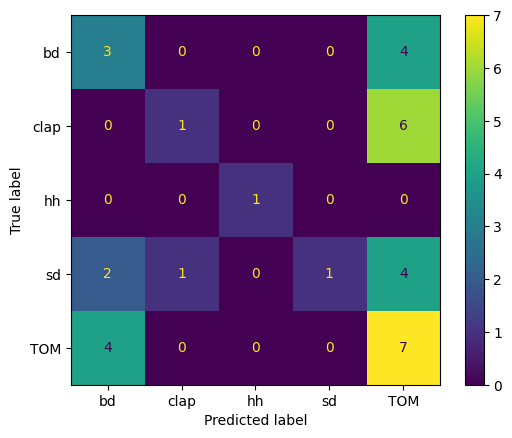

In [87]:
print(classification_report(y_test, pred_mlpc))
print(confusion_matrix(y_test, pred_mlpc))
cm = confusion_matrix(y_test, pred_mlpc)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot()

From this example you can make some observations that generally hold:
<ul>
    <li>Classifiers perform much better during training than during testing</li>
    <li>When one class is overly present during training, most items will be classified as this class (e.g., TOM)</li>
</ul>

Classifiers even tend to find statistical relationships when the features are nonsensical, i.e., when there is NO CAUSAL RELATIONSHIP between the fetures and the class. This is quite obvious from a mathematical viewpoint. As long as the data is less random than white noise, some general trands are observable. Identifying these trends (vaguely) leads to a classification above chance level. This is the most dangerous thing about classifiers: They only find statistical relationships. You as a researcher have to make sure that the features make sense. We therefore talk about "interpretability" or "intuitiveness" of the data. Not only should the classifier perform well. It is also important that obvious examples are classified right, it is fine if vague items are misclassified... 

# Convolution Neural Network
Convolutional Neural Networks (CNNs) are related to multi layer perceptrons. But instead of using all layers to modify the feature input, additional layers "scan" this input space (in fact, this is a correlation, implemented through a fast convolution method) for the presence of a particular pattern. Originally, this approach was meant to scan, e.g., a photograph for a particular characteristic, from certain edges, over specific shapes, to whole objects.

First, you have to build the CNN model itself. In textbooks, you mostly find ways to analyze two-dimensional feature arrays, like pixel values from graphics, spectrograms in Hertz, in Mel, or in Bark. A 1D-case, as with time series or a bunch of features, looks a bit different:

In [140]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [146]:
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(5, 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

The model description above is not a must at all! Ideally, you play around with different filters, sizes, and network architectures. In any way, you have to compile the model before running it:

In [147]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [148]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_data=(X_test, y_test_one_hot))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2915 - loss: 1.6467 - val_accuracy: 0.3529 - val_loss: 1.6472
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3059 - loss: 1.6393 - val_accuracy: 0.4118 - val_loss: 1.6294
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3520 - loss: 1.5927 - val_accuracy: 0.3824 - val_loss: 1.6201
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3216 - loss: 1.6087 - val_accuracy: 0.3824 - val_loss: 1.6151
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3342 - loss: 1.5725 - val_accuracy: 0.3824 - val_loss: 1.6157
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3533 - loss: 1.5664 - val_accuracy: 0.3824 - val_loss: 1.6168
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3589 - loss: 1.5654 - val_accuracy: 0.3529 - val_loss: 1.6165
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3522 - loss: 1.5564 - val_accuracy: 0.3529 - val_loss: 1.6159
Epoc

In [150]:
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Accuracy: {accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3199 - loss: 1.6164 
Accuracy: 0.3235294222831726


You can apply the trained CNN on new data now:

In [ ]:
#predictions = model.predict(X_new_data)

Naturally, you can save the trained model in a file and import it later or in another python file using:

In [155]:
model.save('cnn_drums.keras')

In [156]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('cnn_drums.keras')
#predictions = loaded_model.predict(X_new_data)

You can report the same statistics as for the other models, but in a slightly different way. Note that the performance is not necessarily better than the performance of any other machine learning approach. The strength of convolutional neural networks unfolds when you use it in the optimal way. Often, they are used on linear spectrograms or Bark-Band spectrograms, or Mel-frequency spectrograms and not on extracted features. Moreover, a deep neural network makes more sense if you feed it with a liong feature vector or array, or with raw data.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         8
           4       0.33      1.00      0.50        11

    accuracy                           0.32        34
   macro avg       0.07      0.20      0.10        34
weighted avg       0.11      0.32      0.16        34



C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t_ziemer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

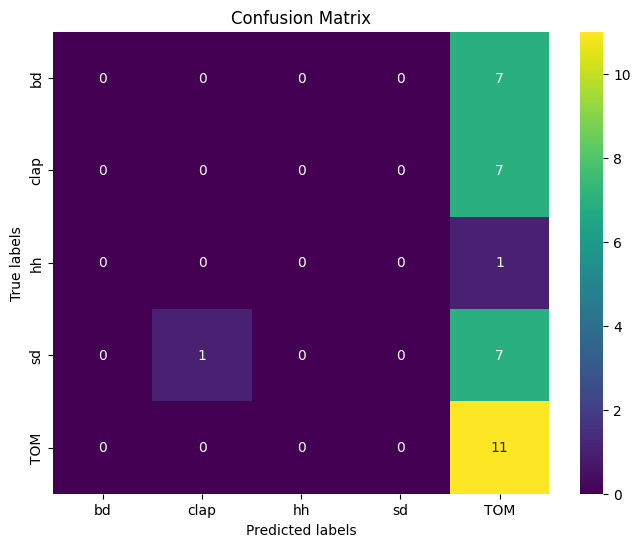

In [168]:
y_pred_test = model.predict(X_test)
y_pred_test_classes = y_pred_test.argmax(axis=1)

# Convert one-hot encoded y_true_test to class labels
y_true_test_classes = y_test_one_hot.argmax(axis=1)

# Display classification report
print(classification_report(y_true_test_classes, y_pred_test_classes))

conf_matrix = confusion_matrix(y_true_test_classes, y_pred_test_classes)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()